<a href="https://colab.research.google.com/github/promckkon/MK-DCNN/blob/main/MK-DCNN%20with%2040dB%20NOISE%20in%20CWRU%20Dataset%20250617.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [100]:
import scipy.io
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

Dataset Input

In [101]:
df=pd.DataFrame(columns=['DE_data','fault']) # upload the dataset on googledrive

for root, dirs, files in os.walk("/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2_NOISE_40", topdown=False):
    for file_name in files:
        path = os.path.join(root, file_name)
        print(path)

        mat = scipy.io.loadmat(path)

        key_name = list(mat.keys())[3]
        DE_data = mat.get(key_name)
        fault = np.full((len(DE_data), 1), file_name[:-4])

        df_temp = pd.DataFrame({'DE_data':np.ravel(DE_data) , 'fault':np.ravel(fault)})

        df = pd.concat([df,df_temp],axis=0)
        print(df['fault'].unique())

df.to_csv('/content/drive/MyDrive/MK-DCNN CWRU/NOISE_40_faults.csv',index=False)

/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2_NOISE_40/Noise_40__Time_Normal_1_098.mat


<ipython-input-101-31565605>:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df_temp],axis=0)


['Noise_40__Time_Normal_1_098']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2_NOISE_40/Noise_40_B007_1_123.mat
['Noise_40__Time_Normal_1_098' 'Noise_40_B007_1_123']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2_NOISE_40/Noise_40_OR014_6_1_202.mat
['Noise_40__Time_Normal_1_098' 'Noise_40_B007_1_123'
 'Noise_40_OR014_6_1_202']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2_NOISE_40/Noise_40_B021_1_227.mat
['Noise_40__Time_Normal_1_098' 'Noise_40_B007_1_123'
 'Noise_40_OR014_6_1_202' 'Noise_40_B021_1_227']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2_NOISE_40/Noise_40_IR021_1_214.mat
['Noise_40__Time_Normal_1_098' 'Noise_40_B007_1_123'
 'Noise_40_OR014_6_1_202' 'Noise_40_B021_1_227' 'Noise_40_IR021_1_214']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2_NOISE_40/Noise_40_B014_1_190.mat
['Noise_40__Time_Normal_1_098' 'Noise_40_B007_1_123'
 'Noise_40_OR014_6_1_202' 'Noise_40_B021_1_227' 'Noise_40_IR021_1_214'
 'Noise_40_B014_1_190']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2_NOISE_40/Noise

# Multi-Kernel Deep 1D-CNN

In [102]:
pip install -q tensorflow

In [103]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


# Total target rows
TARGET_ROWS = 1800

# Estimate the total number of samples across all fault types
total_samples = sum(len(df[df['fault'] == f]) for f in df['fault'].unique())

# Calculate suitable window size and stride
num_faults = 9
average_samples_per_fault = total_samples / num_faults
approx_windows_per_fault = TARGET_ROWS / num_faults
stride_ratio = 0.8  # Initial stride/window ratio

win_len = int(average_samples_per_fault / approx_windows_per_fault)
stride = int(win_len * stride_ratio)

X=[]
Y=[]


for k in df['fault'].unique():

    df_temp_2 = df[df['fault']==k]

    for i in np.arange(0,len(df_temp_2)-(win_len),stride):
        temp = df_temp_2.iloc[i:i+win_len,:-1].values
        temp = temp.reshape((1,-1))
        X.append(temp)
        Y.append(df_temp_2.iloc[i+win_len,-1])

X=np.array(X)
X=X.reshape((X.shape[0],-1,1))
#X = np.repeat(X, 3, axis=3) # To repeat into 3 chanel format


Y=np.array(Y)
encoder= LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

In [104]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)

In [105]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv1D, MaxPooling1D, concatenate
from tensorflow.keras import backend as K

# --- Custom Physics-Informed Loss Function ---
def custom_loss(y_true, y_pred):
    # Standard categorical crossentropy
    loss = K.categorical_crossentropy(y_true, y_pred)

    # Physics-Informed Term: penalize rapid class probability changes
    # Ensure y_pred is at least 2D for slicing
    if K.ndim(y_pred) < 2:
        y_pred = K.expand_dims(y_pred, axis=-1)

    # Ensure y_pred has more than one class dimension to compute diff
    if K.int_shape(y_pred)[-1] > 1:
        diff = y_pred[:, 1:] - y_pred[:, :-1]
        squared_diff = tf.square(diff)
        physics_term = tf.reduce_mean(squared_diff)
    else:
        physics_term = 0.0 # No physics term if only one class


    # Total loss = classification loss + regularization term
    total_loss = loss + 0.01 * physics_term  # 0.01 is tunable

    return total_loss

# --- Model Definition ---
# no_classes = len(df['fault'].unique()) # Original line that caused 10 classes
no_classes = len(encoder.classes_) # Use the encoder to get the correct number of classes
print(f"Number of output classes (no_classes): {no_classes}") # Add print statement to verify

input_shape = (X.shape[1], X.shape[2])  # Example: (784, 1)

# Head 1
inputs1 = Input(shape=input_shape)
conv1 = Conv1D(filters=64, kernel_size=200, activation='relu')(inputs1)
drop1 = Dropout(0.5)(conv1)
pool1 = MaxPooling1D(pool_size=20)(drop1)
flat1 = Flatten()(pool1)

# Head 2
inputs2 = Input(shape=input_shape)
conv2 = Conv1D(filters=64, kernel_size=100, activation='relu')(inputs2)
drop2 = Dropout(0.5)(conv2)
pool2 = MaxPooling1D(pool_size=10)(drop2)
flat2 = Flatten()(pool2)

# Head 3
inputs3 = Input(shape=input_shape)
conv3 = Conv1D(filters=64, kernel_size=50, activation='relu')(inputs3)
drop3 = Dropout(0.5)(conv3)
pool3 = MaxPooling1D(pool_size=5)(drop3)
flat3 = Flatten()(pool3)

# Merge all feature paths
merged = concatenate([flat1, flat2, flat3])

# Fully connected interpretation
dense1 = Dense(100, activation='relu')(merged)
outputs = Dense(no_classes, activation='softmax')(dense1)

# Build and compile model with custom loss
cnn_model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
cnn_model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

# Model summary
cnn_model.summary()

Number of output classes (no_classes): 9


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 2373, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_10      │ (None, 2373, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, 2373, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 2174, 64)  │     12,864 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 2274, 64)  │      6,464 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 2324, 64)  │      3,264 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 2174, 64)  │          0 │ conv1d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 2274, 64)  │          0 │ conv1d_10[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 2324, 64)  │          0 │ conv1d_11[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_9     │ (None, 108, 64)   │          0 │ dropout_9[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_10    │ (None, 227, 64)   │          0 │ dropout_10[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_11    │ (None, 464, 64)   │          0 │ dropout_11[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_9 (Flatten) │ (None, 6912)      │          0 │ max_pooling1d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 14528)     │          0 │ max_pooling1d_10… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_11          │ (None, 29696)     │          0 │ max_pooling1d_11… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 51136)     │          0 │ flatten_9[0][0],  │
│ (Concatenate)       │                   │            │ flatten_10[0][0], │
│                     │                   │            │ flatten_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 100)       │  5,113,700 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 9)         │        909 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,137,201 (19.60 MB)

 Trainable params: 5,137,201 (19.60 MB)

 Non-trainable params: 0 (0.00 B)

In [106]:
batch_size =100
epochs = 20
history = cnn_model.fit([X_train,X_train,X_train], y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=([X_test,X_test,X_test],y_test),shuffle=True)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 897ms/step - accuracy: 0.1215 - loss: 3.6510 - val_accuracy: 0.2359 - val_loss: 1.9060
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3414 - loss: 1.6256 - val_accuracy: 0.5549 - val_loss: 1.3549
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6935 - loss: 1.0006 - val_accuracy: 0.8427 - val_loss: 0.8887
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9293 - loss: 0.4574 - val_accuracy: 0.8991 - val_loss: 0.4991
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9558 - loss: 0.1940 - val_accuracy: 0.9214 - val_loss: 0.3257
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9801 - loss: 0.1046 - val_accuracy: 0.9273 - val_loss: 0.2758
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9809 - loss: 0.0797 - val_accuracy: 0.9451 - val_loss: 0.2280
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9889 - loss: 0.0520 - val_accuracy: 0.9674 -

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step


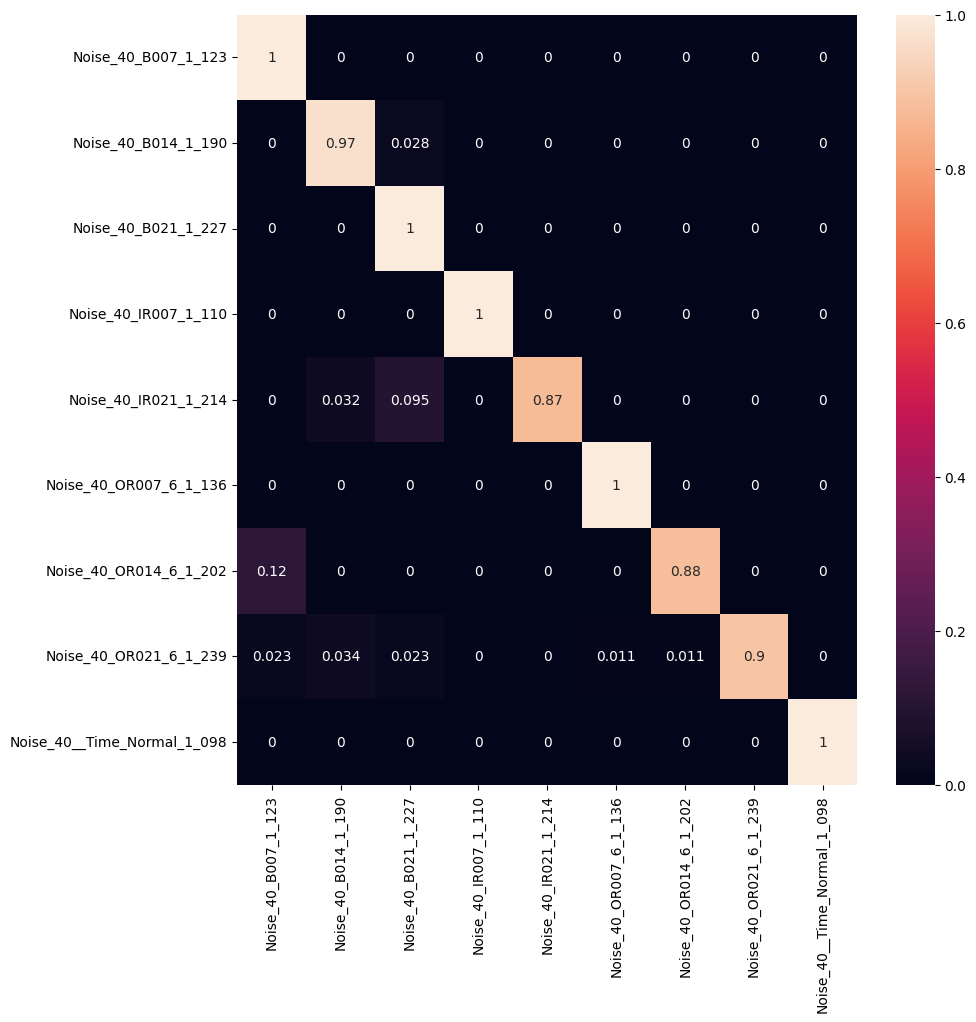

In [107]:
def inv_Transform_result(y_pred):
    y_pred = y_pred.argmax(axis=1)
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred



y_pred=cnn_model.predict([X_test,X_test,X_test])


Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix


plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True,xticklabels=encoder.classes_,yticklabels=encoder.classes_)

In [108]:
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[16].output)
y_viz = dummy_cnn.predict([X_train,X_train,X_train])

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1570 samples in 0.001s...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 1570 samples in 0.169s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1570
[t-SNE] Computed conditional probabilities for sample 1570 / 1570
[t-SNE] Mean sigma: 1.824380
[t-SNE] Computed conditional probabilities in 0.064s
[t-SNE] Iteration 50: error = 57.8451195, gradient norm = 0.0423732 (50 iterations in 0.843s)
[t-SNE] Iteration 100: error = 52.8583260, gradient norm = 0.0144467 (50 iterations in 0.481s)
[t-SNE] Iteration 150: error = 51.7545090, gradient norm = 0.0104074 (50 iterations in 0.470s)
[t-SNE] Iteration 200: error = 51.2341461, gradient norm = 0.0064906 (50 iterations in 0.492s)
[t-SNE] Iteration 250: error = 50.9262161, gradient norm = 0.0048943 (50 iterations in 0.436s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.926216
[t-SNE] Iteration 300: error = 0.9270270, gradient norm = 0.0160632 (50 iterations in 0.441s)
[t-SNE] Iteration 350: error = 0.6730396, gradient norm = 0.0143193 (50 iterations 

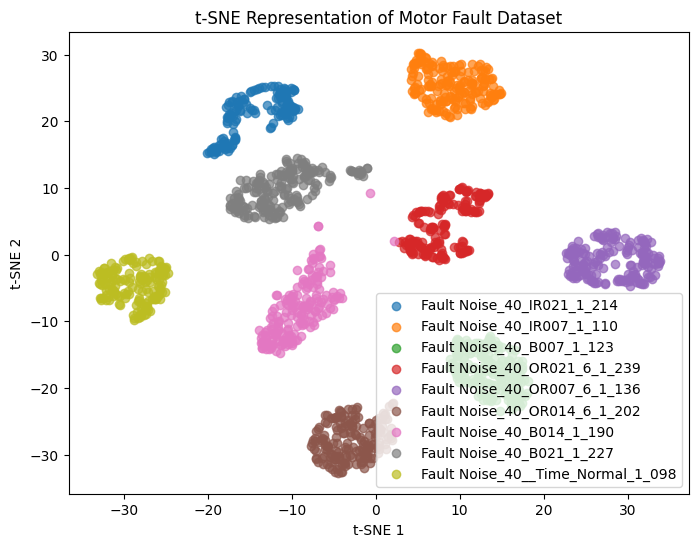

In [109]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Apply t-SNE transformation
X_t_sne = TSNE(
    n_components=2,
    learning_rate='auto',
    verbose=2,  # Increase verbosity for more detailed feedback
    perplexity=40,
    n_iter=500  # Slightly increased number of iterations for convergence
).fit_transform(y_viz)

# Create DataFrame for t-SNE components
tSNEdf = pd.DataFrame(data=X_t_sne, columns=['T-SNE component 1', 'T-SNE component 2'])

# Assuming `inv_Transform_result` transforms `y_train` to get the Fault labels
tSNEdf['Fault'] = inv_Transform_result(y_train)

# Save the t-SNE DataFrame as a CSV file
tSNEdf.to_csv('/content/drive/MyDrive/MK-DCNN CWRU/NOISE_40_tSNE_results.csv', index=True)
print("t-SNE results saved as '/content/drive/MyDrive/MK-DCNN CWRU/NOISE_40_tSNE_results.csv'.")

# # Plot the t-SNE results with Fault as hue
# plt.figure(figsize=(12, 12))  # Larger figure for clarity
# sns.scatterplot(
#     x='T-SNE component 1',
#     y='T-SNE component 2',
#     hue='Fault',
#     palette=sns.color_palette("husl", as_cmap=False),  # Vivid color palette
#     data=tSNEdf,
#     legend="full",
#     alpha=0.7,  # Increased transparency for better overlap clarity
#     s=100  # Larger marker size
# )

# # Add gridlines for better visualization
# plt.grid


# Optional: Visualization of t-SNE representation
plt.figure(figsize=(8, 6))
for label in tSNEdf['Fault'].unique():
    subset = tSNEdf[tSNEdf['Fault'] == label]
    plt.scatter(subset['T-SNE component 1'], subset['T-SNE component 2'], label=f'Fault {label}', alpha=0.7)

plt.title('t-SNE Representation of Motor Fault Dataset')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.show()

Statistical Features

In [110]:
import numpy as np
from scipy.stats import skew, kurtosis
import pandas as pd
import matplotlib.pyplot as plt

# Total target rows
TARGET_ROWS = 1800

# Estimate the total number of samples across all fault types
total_samples = sum(len(df[df['fault'] == f]) for f in df['fault'].unique())

# Calculate suitable window size and stride
num_faults = 9
average_samples_per_fault = total_samples / num_faults
approx_windows_per_fault = TARGET_ROWS / num_faults
stride_ratio = 0.8  # Initial stride/window ratio

WINDOW_SIZE = int(average_samples_per_fault / approx_windows_per_fault)
STRIDE = int(WINDOW_SIZE * stride_ratio)

print(f"Calculated WINDOW_SIZE: {WINDOW_SIZE}, STRIDE: {STRIDE}")

# Initialize a list to store statistical features
statistical_features = []

# Loop through each fault type
for f in df['fault'].unique():
    # Extract data for the current fault type
    fault_data = df[df['fault'] == f].iloc[:, 0].values  # Convert to NumPy array for efficiency

    # Compute windows using sliding window approach
    num_windows = (len(fault_data) - WINDOW_SIZE) // STRIDE + 1
    for i in range(num_windows):
        start = i * STRIDE
        end = start + WINDOW_SIZE
        window = fault_data[start:end]

        # Compute statistical features for the current window
        mean_val = np.mean(window)
        std_val = np.std(window)
        rms_val = np.sqrt(np.mean(np.square(window)))
        max_val = np.max(window)
        min_val = np.min(window)
        skewness_val = skew(window)
        kurtosis_val = kurtosis(window)

        # Additional statistical features
        mean_abs_val = np.mean(np.abs(window))
        form_factor = rms_val / mean_abs_val if mean_abs_val != 0 else 0
        crest_factor = max_val / rms_val if rms_val != 0 else 0

        # Store the features in a dictionary
        statistical_features.append({
            'fault': f,
            'window': i + 1,
            'mean': mean_val,
            'std': std_val,
            'rms': rms_val,
            'max': max_val,
            'min': min_val,
            'skewness': skewness_val,
            'kurtosis': kurtosis_val,
            'form_factor': form_factor,
            'crest_factor': crest_factor
        })

# Convert statistical features into a DataFrame
stat_features_df = pd.DataFrame(statistical_features)

# Display the extracted features and count of rows
print(f"Extracted {len(stat_features_df)} rows (target: {TARGET_ROWS})")
print(stat_features_df)

# Save the extracted features to a CSV file
output_file = "/content/drive/MyDrive/MK-DCNN CWRU/NOISE_40_statistical_features_with_form_and_crest_factors.csv"
stat_features_df.to_csv(output_file, index=False)
print(f"Statistical features saved to '{output_file}'.")


Calculated WINDOW_SIZE: 2373, STRIDE: 1898
Extracted 2244 rows (target: 1800)
                            fault  window      mean       std       rms  \
0     Noise_40__Time_Normal_1_098       1  0.008091  0.065018  0.065519   
1     Noise_40__Time_Normal_1_098       2  0.009812  0.063296  0.064052   
2     Noise_40__Time_Normal_1_098       3  0.011155  0.063354  0.064329   
3     Noise_40__Time_Normal_1_098       4  0.011241  0.062892  0.063889   
4     Noise_40__Time_Normal_1_098       5  0.012030  0.063670  0.064796   
...                           ...     ...       ...       ...       ...   
2239         Noise_40_IR007_1_110     251  0.019700  0.275898  0.276601   
2240         Noise_40_IR007_1_110     252  0.019795  0.269157  0.269884   
2241         Noise_40_IR007_1_110     253  0.018081  0.270197  0.270802   
2242         Noise_40_IR007_1_110     254  0.018727  0.285200  0.285814   
2243         Noise_40_IR007_1_110     255  0.019930  0.268406  0.269145   

           max       

In [111]:
import pandas as pd
from sklearn.utils import resample

# Load your dataset (replace 'your_dataset.csv' with your actual file)
df = pd.read_csv('/content/drive/MyDrive/MK-DCNN CWRU/NOISE_40_statistical_features_with_form_and_crest_factors.csv')

# Display initial class distribution
print("Initial class distribution:")
print(df['fault'].value_counts())

# Target size for undersampling/resampling
TARGET_ROWS = 1570

# Separate all fault types
fault_classes = df['fault'].value_counts()

# Determine the number of classes
num_classes = len(fault_classes)

# Calculate how many samples to take from each class
samples_per_class = TARGET_ROWS // num_classes

# Initialize a list to store resampled data
resampled_data = []

# Loop over each class to resample them
for fault_class in fault_classes.index:
    class_data = df[df['fault'] == fault_class]
    if len(class_data) > samples_per_class:
        # Undersample
        class_data_resampled = resample(class_data, replace=False, n_samples=samples_per_class, random_state=42)
    else:
        # Upsample
        class_data_resampled = resample(class_data, replace=True, n_samples=samples_per_class, random_state=42)

    resampled_data.append(class_data_resampled)

# Concatenate the resampled data into a single DataFrame
balanced_df = pd.concat(resampled_data)

# Check if we have the exact number of rows
current_rows = len(balanced_df)
print(f"Current rows after equal resampling: {current_rows}")

# If the current rows don't match the target rows, adjust by trimming or adding rows
if current_rows > TARGET_ROWS:
    # Trim extra rows (if more than target)
    balanced_df = balanced_df.head(TARGET_ROWS)
elif current_rows < TARGET_ROWS:
    # Add rows if fewer than target, by sampling from existing data
    remaining_rows = TARGET_ROWS - current_rows
    additional_data = balanced_df.sample(n=remaining_rows, replace=True, random_state=42)
    balanced_df = pd.concat([balanced_df, additional_data])

# Shuffle the final dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display new class distribution
print("New class distribution:")
print(balanced_df['fault'].value_counts())

# Display final row count
print(f"Final row count: {len(balanced_df)}")

# Save the balanced dataset to a CSV file
balanced_df.to_csv("/content/drive/MyDrive/MK-DCNN CWRU/NOISE_40_balanced_dataset_equal_resampling_exact_1570.csv", index=False)
print("Balanced dataset saved as '/content/drive/MyDrive/MK-DCNN CWRU/NOISE_40_balanced_dataset_equal_resampling_exact_1570.csv'")


Initial class distribution:
fault
Noise_40_OR021_6_1_239         257
Noise_40_OR007_6_1_136         256
Noise_40_B007_1_123            256
Noise_40_B021_1_227            256
Noise_40_B014_1_190            255
Noise_40_IR007_1_110           255
Noise_40_OR014_6_1_202         255
Noise_40__Time_Normal_1_098    254
Noise_40_IR021_1_214           200
Name: count, dtype: int64
Current rows after equal resampling: 1566
New class distribution:
fault
Noise_40_IR021_1_214           175
Noise_40_OR014_6_1_202         175
Noise_40__Time_Normal_1_098    175
Noise_40_B014_1_190            175
Noise_40_IR007_1_110           174
Noise_40_B021_1_227            174
Noise_40_B007_1_123            174
Noise_40_OR007_6_1_136         174
Noise_40_OR021_6_1_239         174
Name: count, dtype: int64
Final row count: 1570
Balanced dataset saved as '/content/drive/MyDrive/MK-DCNN CWRU/NOISE_40_balanced_dataset_equal_resampling_exact_1570.csv'


In [112]:
balanced_df.shape

(1570, 11)

In [113]:
balanced_df=balanced_df.sort_values(by='fault')

In [114]:
balanced_df

,fault,window,mean,std,rms,max,min,skewness,kurtosis,form_factor,crest_factor
214,Noise_40_B007_1_123,33,0.019629,0.140407,0.141773,0.439416,-0.358631,-0.028402,-0.123641,1.258250,3.099443
637,Noise_40_B007_1_123,166,0.020638,0.115164,0.116999,0.368367,-0.327156,-0.033925,-0.248327,1.239579,3.148462
863,Noise_40_B007_1_123,66,0.019531,0.132267,0.133701,0.527550,-0.445003,-0.029578,0.152592,1.264633,3.945745
298,Noise_40_B007_1_123,17,0.017231,0.144248,0.145273,0.664086,-0.513632,0.152920,1.047149,1.321047,4.571294
858,Noise_40_B007_1_123,77,0.015802,0.139284,0.140178,0.444921,-0.429993,-0.031670,0.056608,1.252443,3.173982
...,...,...,...,...,...,...,...,...,...,...,...
444,Noise_40__Time_Normal_1_098,163,0.011262,0.065733,0.066690,0.218291,-0.223993,-0.339490,0.087112,1.239305,3.273198
1387,Noise_40__Time_Normal_1_098,40,0.010212,0.066190,0.066973,0.195694,-0.245334,-0.181970,0.082961,1.252341,2.921965
1388,Noise_40__Time_Normal_1_098,224,0.014248,0.063744,0.065317,0.196680,-0.207985,-0.346473,-0.032352,1.229085,3.011154
439,Noise_40__Time_Normal_1_098,115,0.014628,0.063687,0.065346,0.209403,-0.199459,-0.228590,-0.270015,1.223765,3.204540


     t-SNE 1    t-SNE 2                fault
0 -43.489235   6.534474  Noise_40_B007_1_123
1 -32.924328  -8.303387  Noise_40_B007_1_123
2 -36.026554  -7.524638  Noise_40_B007_1_123
3 -40.191689   7.556388  Noise_40_B007_1_123
4 -36.629608 -10.236309  Noise_40_B007_1_123


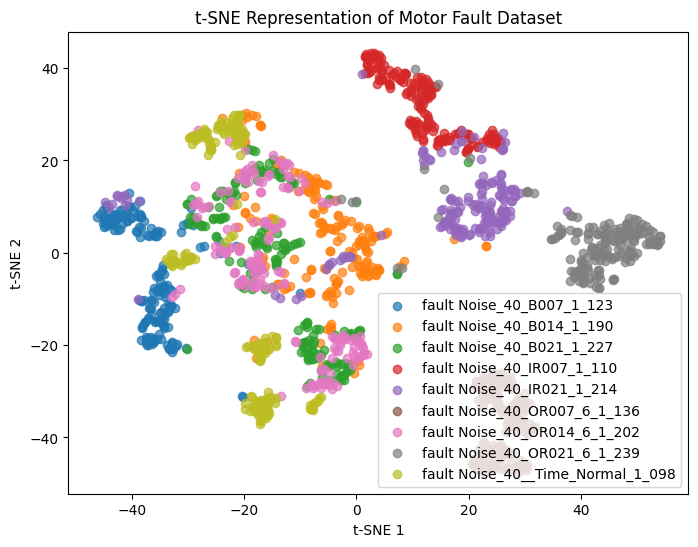

In [115]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Sort the dataset by the 'Fault' column
balanced_df = balanced_df.sort_values(by='fault')

# Separate features and target variable
X = balanced_df.drop(columns=['fault'])  # Replace 'Fault' with actual target column name
y = balanced_df['fault']

# Normalize the feature columns using StandardScaler
scaler = StandardScaler()
X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Concatenate the normalized features with the target variable
STAT_Motor_Fault_dataset_normalized = pd.concat([X_normalized, y.reset_index(drop=True)], axis=1)

# Sort the normalized dataset by 'Fault' column
STAT_Motor_Fault_dataset_normalized = STAT_Motor_Fault_dataset_normalized.sort_values(by='fault')

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)  # 2D t-SNE
X_tsne = tsne.fit_transform(X_normalized)

# Create a DataFrame for t-SNE results
tSNE_representation = pd.DataFrame(X_tsne, columns=['t-SNE 1', 't-SNE 2'])
tSNE_representation['fault'] = y.reset_index(drop=True)

# Display the t-SNE representation
print(tSNE_representation.head())

# Optional: Visualization of t-SNE representation
plt.figure(figsize=(8, 6))
for label in tSNE_representation['fault'].unique():
    subset = tSNE_representation[tSNE_representation['fault'] == label]
    plt.scatter(subset['t-SNE 1'], subset['t-SNE 2'], label=f'fault {label}', alpha=0.7)

plt.title('t-SNE Representation of Motor Fault Dataset')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.show()


In [116]:
tSNE_representation

,t-SNE 1,t-SNE 2,fault
0,-43.489235,6.534474,Noise_40_B007_1_123
1,-32.924328,-8.303387,Noise_40_B007_1_123
2,-36.026554,-7.524638,Noise_40_B007_1_123
3,-40.191689,7.556388,Noise_40_B007_1_123
4,-36.629608,-10.236309,Noise_40_B007_1_123
...,...,...,...
1565,-16.823854,-33.658577,Noise_40__Time_Normal_1_098
1566,-16.123884,-19.606106,Noise_40__Time_Normal_1_098
1567,-26.544622,24.804104,Noise_40__Time_Normal_1_098
1568,-21.286615,27.123165,Noise_40__Time_Normal_1_098


In [117]:
tSNE_representation=tSNE_representation.drop(columns=['fault'])
tSNE_representation

,t-SNE 1,t-SNE 2
0,-43.489235,6.534474
1,-32.924328,-8.303387
2,-36.026554,-7.524638
3,-40.191689,7.556388
4,-36.629608,-10.236309
...,...,...
1565,-16.823854,-33.658577
1566,-16.123884,-19.606106
1567,-26.544622,24.804104
1568,-21.286615,27.123165


In [118]:
tSNEdf = tSNEdf.sort_values(by='Fault')

In [119]:
tSNEdf

,T-SNE component 1,T-SNE component 2,Fault
801,17.377424,-21.005064,Noise_40_B007_1_123
171,10.048149,-14.180998,Noise_40_B007_1_123
1394,13.940641,-17.930798,Noise_40_B007_1_123
1069,9.660629,-12.681634,Noise_40_B007_1_123
1071,17.380924,-17.218872,Noise_40_B007_1_123
...,...,...,...
129,-30.513121,-3.987570,Noise_40__Time_Normal_1_098
530,-29.424301,-0.448983,Noise_40__Time_Normal_1_098
1440,-25.351404,-3.035061,Noise_40__Time_Normal_1_098
319,-26.503349,-5.481032,Noise_40__Time_Normal_1_098


Combined Features

In [120]:
# import pandas as pd

# Assuming df1 and df2 are your two dataframes
# Concatenate the dataframes vertically
Motor_Fault_dataset = pd.concat([tSNE_representation, tSNEdf], axis=1)
Motor_Fault_dataset=Motor_Fault_dataset.sort_values(by='Fault')
Motor_Fault_dataset

import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming df1 and df2 are your two dataframes
# Concatenate the dataframes vertically
Motor_Fault_dataset = pd.concat([tSNE_representation, tSNEdf], axis=1)

# Sort the dataset by 'Fault' column
Motor_Fault_dataset = Motor_Fault_dataset.sort_values(by='Fault')
Motor_Fault_dataset


,t-SNE 1,t-SNE 2,T-SNE component 1,T-SNE component 2,Fault
801,16.490799,7.798335,17.377424,-21.005064,Noise_40_B007_1_123
171,-20.270432,-31.136820,10.048149,-14.180998,Noise_40_B007_1_123
1394,31.573549,12.991084,13.940641,-17.930798,Noise_40_B007_1_123
1069,-20.148972,-5.803549,9.660629,-12.681634,Noise_40_B007_1_123
1071,-13.273790,19.499327,17.380924,-17.218872,Noise_40_B007_1_123
...,...,...,...,...,...
129,-24.276953,0.063847,-30.513121,-3.987570,Noise_40__Time_Normal_1_098
530,12.830428,28.585051,-29.424301,-0.448983,Noise_40__Time_Normal_1_098
1440,-16.993561,-32.970127,-25.351404,-3.035061,Noise_40__Time_Normal_1_098
319,7.755459,-2.844370,-26.503349,-5.481032,Noise_40__Time_Normal_1_098


In [121]:
#Classification Report for MKDCNN

HSPSO-CatBoost


In [122]:
X = Motor_Fault_dataset.iloc[:, 0:4].values
y = Motor_Fault_dataset.iloc[:, 4].values

In [123]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [124]:
pip install -q hyperactive

In [125]:
pip install -q catboost

Deployment:

In [126]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier, Pool
from hyperactive import Hyperactive
from hyperactive.optimizers import ParticleSwarmOptimizer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === DATA: Replace X_train, X_test, y_train, y_test with your actual data ===
# Example:
# X_train, X_test, y_train, y_test = train_test_split(...)

X, y = X_train, y_train

# === Objective Function ===
def model(opt):
    CatBoost = CatBoostClassifier(
        iterations=opt["iterations"],
        depth=opt["depth"],
        learning_rate=opt["learning_rate"],
        l2_leaf_reg=opt["l2_leaf_reg"],
        bagging_temperature=opt["bagging_temperature"],
        random_strength=opt["random_strength"],
        verbose=False
    )
    scores = cross_val_score(CatBoost, X, y, cv=4)
    return scores.mean()

# === Search Space ===
search_space = {
    "iterations": list(range(50, 501, 50)),
    "depth": list(range(1, 11)),
    "learning_rate": [0.01, 0.05, 0.1],
    "l2_leaf_reg": [1, 3, 5],
    "bagging_temperature": [0.5, 1, 1.5],
    "random_strength": [0.5, 1, 1.5],
}

# === Cauchy Mutation ===
def cauchy_mutation(particle, gamma=0.3):
    for key in particle:
        if isinstance(particle[key], (int, float)):
            particle[key] = particle[key] * (1 + gamma * np.tan(np.pi * (np.random.rand() - 0.5)))
            particle[key] = np.clip(particle[key], min(search_space[key]), max(search_space[key]))
            if isinstance(search_space[key][0], int):
                particle[key] = int(round(particle[key]))
    return particle

# === HSPSO Optimizer Class ===
class HybridStrategyPSO(ParticleSwarmOptimizer):
    def __init__(self, n_part=20, max_iter=40, **kwargs):
        super().__init__(**kwargs)
        self.switch_threshold = 10
        self.iteration = 0
        self.topology = "gbest"
        self.n_part = n_part
        self.max_iter = max_iter

        # Adaptive Inertia Parameters
        self.H = 1
        self.w_min = 0.4
        self.w_max = 0.9
        self.b = 0.9
        self.scaling_factor = 0.5

    def on_iteration(self, swarm, scores):
        self.iteration += 1

        # === Topology Switching ===
        if self.iteration % self.switch_threshold == 0:
            self.topology = "lbest" if self.topology == "gbest" else "gbest"
            self.set_topology(self.topology)

        # === Clone Best Particles ===
        best_indices = np.argsort(scores)[:max(1, len(swarm) // 5)]
        for idx in best_indices:
            particle = swarm[idx].copy()
            swarm.append(particle)
            scores.append(scores[idx])

        # === Prune Worst Particles ===
        if len(swarm) > 2 * self.n_part:
            worst_indices = np.argsort(scores)[-len(swarm)//4:]
            for i in reversed(worst_indices):
                del swarm[i]
                del scores[i]

        # === Nonlinear Adaptive Inertia ===
        numerator = (self.w_max - self.w_min) * self.iteration
        denominator = 1 + np.exp(-10 * self.b * ((2 * self.iteration) / (self.H * self.max_iter) - 1))
        self.inertia = self.w_max - numerator / denominator

        # === Cauchy Mutation ===
        for i in range(len(swarm)):
            if np.random.rand() < 0.2:
                swarm[i] = cauchy_mutation(swarm[i])

        # === Hook-Jeeves Local Search (simplified) ===
        top_ids = np.argsort(scores)[:2]
        for i in top_ids:
            particle = swarm[i]
            for key in particle:
                if isinstance(particle[key], (int, float)):
                    for delta in [-0.01, 0.01] if isinstance(particle[key], float) else [-1, 1]:
                        trial = particle.copy()
                        trial[key] = trial[key] + delta
                        trial[key] = np.clip(trial[key], min(search_space[key]), max(search_space[key]))
                        if isinstance(search_space[key][0], int):
                            trial[key] = int(round(trial[key]))
                        trial_score = model(trial)
                        if trial_score > scores[i]:
                            swarm[i] = trial
                            scores[i] = trial_score

        # === Random Restart ===
        if np.random.rand() < 0.1:
            random_idx = np.random.choice(len(swarm))
            for key in swarm[random_idx]:
                if isinstance(swarm[random_idx][key], (int, float)):
                    swarm[random_idx][key] = np.random.choice(search_space[key])

# === Run HSPSO Hyperparameter Tuning ===
start_time = datetime.now()

hyper = Hyperactive()

optimizer = HybridStrategyPSO(
    n_part=20,
    max_iter=40,
    inertia=0.5,
    cognitive_weight=0.9,
    social_weight=0.5,
    temp_weight=0.4,
    rand_rest_p=0.05,
)

hyper.add_search(model, search_space, optimizer=optimizer, n_iter=40)
hyper.run()

end_time = datetime.now()
print('Tuning Duration:', end_time - start_time)

# === Best Parameters ===
best_params = hyper.best_para(model)
print("Best Parameters:", best_params)

# === Train Final Model with Best Parameters ===
train_pool = Pool(data=X_train, label=y_train)
test_pool = Pool(data=X_test, label=y_test)

final_model = CatBoostClassifier(
    depth=best_params["depth"],
    iterations=best_params["iterations"],
    learning_rate=best_params["learning_rate"],
    l2_leaf_reg=best_params["l2_leaf_reg"],
    bagging_temperature=best_params["bagging_temperature"],
    random_strength=best_params["random_strength"],
    verbose=10
)

final_model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=best_params["iterations"] // 10,
    plot=True
)


[0] model (Particle Swarm Optimization): 100%|──────────| 40/40 [03:16<00:00,  4.91s/it, best_iter=0, best_pos=None, best_score=-inf]



Results: 'model'  
   Best score: 0.9968152866242037  
   Best parameter set:
      'iterations'          : 300.0  
      'depth'               : 7.0  
      'learning_rate'       : 0.01  
      'l2_leaf_reg'         : 3.0  
      'bagging_temperature' : 0.5  
      'random_strength'     : 1.0  
   Best iteration: 0  
 
   Random seed: 785903007  
 
   Evaluation time   : 196.0491542816162 sec    [100.0 %]
   Optimization time : 0.009029388427734375 sec    [0.0 %]
   Iteration time    : 196.05818367004395 sec    [4.9 sec/iter]
 
Tuning Duration: 0:03:16.407600
Best Parameters: {'iterations': 300, 'depth': 7, 'learning_rate': 0.01, 'l2_leaf_reg': 3, 'bagging_temperature': 0.5, 'random_strength': 1}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.1434354	test: 2.1427332	best: 2.1427332 (0)	total: 13.4ms	remaining: 4.01s
30:	learn: 1.2521845	test: 1.2440541	best: 1.2440541 (30)	total: 379ms	remaining: 3.29s
60:	learn: 0.8361278	test: 0.8295565	best: 0.8295565 (60)	total: 731ms	remaining: 2.86s
90:	learn: 0.5909254	test: 0.5835201	best: 0.5835201 (90)	total: 1.12s	remaining: 2.57s
120:	learn: 0.4351236	test: 0.4275185	best: 0.4275185 (120)	total: 1.48s	remaining: 2.19s
150:	learn: 0.3281618	test: 0.3214081	best: 0.3214081 (150)	total: 1.84s	remaining: 1.82s
180:	learn: 0.2524053	test: 0.2456807	best: 0.2456807 (180)	total: 2.22s	remaining: 1.46s
210:	learn: 0.1993913	test: 0.1927904	best: 0.1927904 (210)	total: 2.57s	remaining: 1.08s
240:	learn: 0.1586676	test: 0.1522529	best: 0.1522529 (240)	total: 2.93s	remaining: 717ms
270:	learn: 0.1292834	test: 0.1233202	best: 0.1233202 (270)	total: 3.3s	remaining: 353ms
299:	learn: 0.1081416	test: 0.1024316	best: 0.1024316 (299)	total: 3.63s	remaining: 0us

bestTest = 0.10243162

In [127]:
hyper.add_search(model, search_space, optimizer=optimizer, n_iter=40, initialize={"random": 20})


In [128]:
learning_curve = final_model.get_evals_result()
print(learning_curve)

{'learn': {'MultiClass': [2.143435392236498, 2.090053041234227, 2.043940757170626, 1.9953819254999967, 1.9495763576807266, 1.9162222235458657, 1.8788584000481774, 1.836048906268525, 1.8107888527046998, 1.77112736949232, 1.7398999663356798, 1.7109354050913885, 1.677888892706471, 1.6460783813879016, 1.6188848223697747, 1.589673204766121, 1.557871685634093, 1.5345539169179883, 1.5080862232343348, 1.4845489606664508, 1.4611526980671599, 1.4383537498508798, 1.4166536894873416, 1.3950268835112802, 1.372369830572808, 1.3496358792817207, 1.3297030706914614, 1.3076765439654585, 1.2884101927562819, 1.2690440364198263, 1.2521845066564155, 1.2348798455642123, 1.216010023357921, 1.1983331629307974, 1.1802291615652647, 1.1624601200981755, 1.1455691234806797, 1.1299768180637104, 1.1149514212193998, 1.098564472087146, 1.0828277385871061, 1.0675824339141298, 1.054496851380359, 1.0433562447263638, 1.028210670534916, 1.0136140189696068, 0.9994996889641112, 0.9865793877657022, 0.9740868982666995, 0.962867

In [129]:
# Retrieve evaluation results
learning_curve = final_model.get_evals_result()

# Extract the metric values
# Assuming 'learn' corresponds to the training dataset
train_metric_values = learning_curve.get('learn', {}).get('MultiClass', [])

# Check the extracted values
if train_metric_values:
    print("Training metric values:", train_metric_values)
else:
    print("Metric 'MultiClass' not found in evaluation results.")


Training metric values: [2.143435392236498, 2.090053041234227, 2.043940757170626, 1.9953819254999967, 1.9495763576807266, 1.9162222235458657, 1.8788584000481774, 1.836048906268525, 1.8107888527046998, 1.77112736949232, 1.7398999663356798, 1.7109354050913885, 1.677888892706471, 1.6460783813879016, 1.6188848223697747, 1.589673204766121, 1.557871685634093, 1.5345539169179883, 1.5080862232343348, 1.4845489606664508, 1.4611526980671599, 1.4383537498508798, 1.4166536894873416, 1.3950268835112802, 1.372369830572808, 1.3496358792817207, 1.3297030706914614, 1.3076765439654585, 1.2884101927562819, 1.2690440364198263, 1.2521845066564155, 1.2348798455642123, 1.216010023357921, 1.1983331629307974, 1.1802291615652647, 1.1624601200981755, 1.1455691234806797, 1.1299768180637104, 1.1149514212193998, 1.098564472087146, 1.0828277385871061, 1.0675824339141298, 1.054496851380359, 1.0433562447263638, 1.028210670534916, 1.0136140189696068, 0.9994996889641112, 0.9865793877657022, 0.9740868982666995, 0.9628670

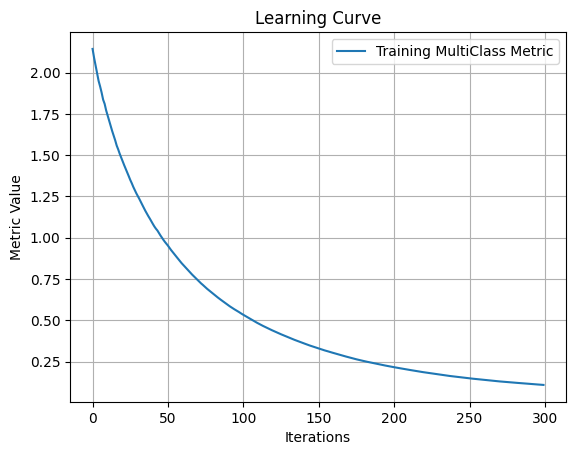

In [130]:
import matplotlib.pyplot as plt

# Plotting the learning curve
plt.plot(train_metric_values, label='Training MultiClass Metric')
plt.xlabel('Iterations')
plt.ylabel('Metric Value')
plt.title('Learning Curve')
plt.legend()
plt.grid()
plt.show()


Classification Report - Training Set:
                             precision    recall  f1-score   support

        Noise_40_B007_1_123       1.00      1.00      1.00       158
        Noise_40_B014_1_190       1.00      0.97      0.99       154
        Noise_40_B021_1_227       0.98      1.00      0.99       146
       Noise_40_IR007_1_110       1.00      1.00      1.00       142
       Noise_40_IR021_1_214       1.00      1.00      1.00       110
     Noise_40_OR007_6_1_136       1.00      1.00      1.00       134
     Noise_40_OR014_6_1_202       1.00      1.00      1.00       141
     Noise_40_OR021_6_1_239       0.99      1.00      1.00       144
Noise_40__Time_Normal_1_098       1.00      1.00      1.00       127

                   accuracy                           1.00      1256
                  macro avg       1.00      1.00      1.00      1256
               weighted avg       1.00      1.00      1.00      1256

Classification Report - Test Set:
                            

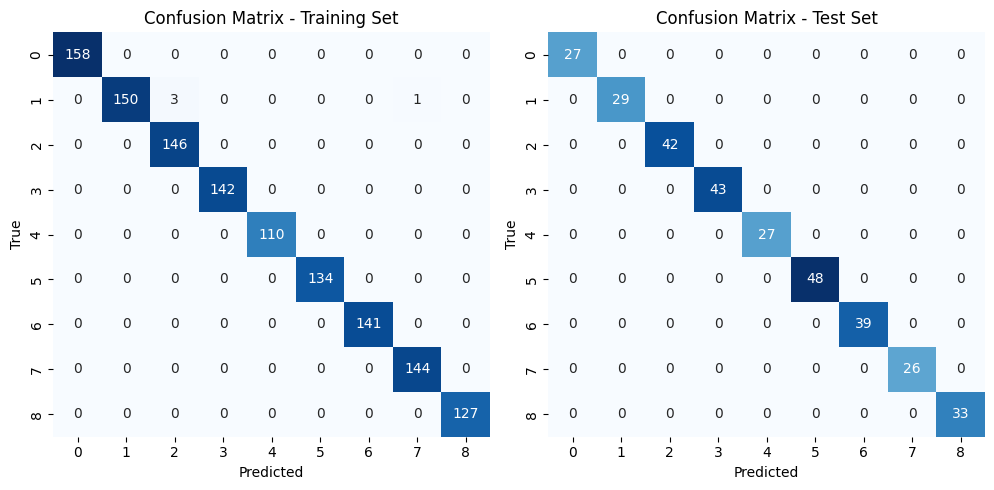

Deployment Duration: 0:03:22.423336


In [131]:
# Predictions
y_pred_train = final_model.predict(X_train)
y_pred_test = final_model.predict(X_test)

print("Classification Report - Training Set:")
print(classification_report(y_train, y_pred_train))

print("Classification Report - Test Set:")
print(classification_report(y_test, y_pred_test))

conf_matrix_train = confusion_matrix(y_train, y_pred_train)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Training Set")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.subplot(1, 3, 2)
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.tight_layout()
plt.savefig('C-Matrix.svg', format='svg')
plt.show()

end_time = datetime.now()
print('Deployment Duration: {}'.format(end_time - start_time))

In [132]:
final_model.fit(X_train, y_train, eval_set=(X_test, y_test))

# Evaluate train accuracy
result_train = final_model.score(X_train, y_train)
print("Train Accuracy : {}".format(result_train))

# Evaluate test accuracy
result_test = final_model.score(X_test, y_test)
print("Test Accuracy : {}".format(result_test))

# Predictions
y_pred_train = final_model.predict(X_train)
y_pred_test = final_model.predict(X_test)

# Classification report
print("Classification Report - Training Set:")
print(classification_report(y_train, y_pred_train))

print("Classification Report - Test Set:")
print(classification_report(y_test, y_pred_test))

0:	learn: 2.1434354	test: 2.1427332	best: 2.1427332 (0)	total: 30.7ms	remaining: 9.19s
10:	learn: 1.7399000	test: 1.7364280	best: 1.7364280 (10)	total: 289ms	remaining: 7.6s
20:	learn: 1.4611527	test: 1.4544156	best: 1.4544156 (20)	total: 556ms	remaining: 7.38s
30:	learn: 1.2521845	test: 1.2440541	best: 1.2440541 (30)	total: 831ms	remaining: 7.21s
40:	learn: 1.0828277	test: 1.0758578	best: 1.0758578 (40)	total: 1.11s	remaining: 7.02s
50:	learn: 0.9514925	test: 0.9447753	best: 0.9447753 (50)	total: 1.38s	remaining: 6.74s
60:	learn: 0.8361278	test: 0.8295565	best: 0.8295565 (60)	total: 1.68s	remaining: 6.58s
70:	learn: 0.7404538	test: 0.7337627	best: 0.7337627 (70)	total: 2.1s	remaining: 6.77s
80:	learn: 0.6599759	test: 0.6531723	best: 0.6531723 (80)	total: 2.37s	remaining: 6.42s
90:	learn: 0.5909254	test: 0.5835201	best: 0.5835201 (90)	total: 2.7s	remaining: 6.19s
100:	learn: 0.5327095	test: 0.5255204	best: 0.5255204 (100)	total: 3.11s	remaining: 6.12s
110:	learn: 0.4799651	test: 0.4726